In [1]:
import requests
import json
import pandas as pd
import numpy as np
import urllib.request
import pymysql
import random

from glob import glob
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

## 1. 코디 이미지 모델 학습

cody_image6으로 학습 진행

In [2]:
target_list = ['Black', 'Navy', 'Pink', 'Green', 'Purple', 'Red', 'Skyblue', 'Yellow']
data = pd.DataFrame()

for color in target_list:
    photo_list = sorted(glob(f"./cody_image6/{color}/*.jpg"))
    
    for photo in photo_list:
        images = cv2.imread(photo)
        
        #RGB 평균 구하기
        arr1 = images[:,:,0].reshape(-1)
        r_mean = arr1[arr1 != 0].mean()
        
        arr1 = images[:,:,1].reshape(-1)
        g_mean = arr1[arr1 != 0].mean()
        
        arr1 = images[:,:,2].reshape(-1)
        b_mean = arr1[arr1 != 0].mean()
        
        #RGB 사이의 차이값 구하기
        rb_diff = abs(r_mean - b_mean)
        rg_diff = abs(r_mean - g_mean)
        gb_diff = abs(g_mean - b_mean)        
        
        pix = cv2.cvtColor(images, cv2.COLOR_BGR2HSV)
        pix_h_data = pix[:,:,0].reshape(-1)  #H부분만 추출
        #all_mean_v = pix[:,:,2].reshape(-1).mean()  #전체 평균 v
        
        unique, counts = np.unique(pix_h_data, return_counts=True)
        color_dict = dict(zip(unique, counts))
        sort_color = dict(sorted(color_dict.items(), key = lambda x: x[1], reverse = True)).keys()
        color_data = pd.DataFrame({'h_mean': [(np.array(list(sort_color))[0:6]).mean()]})  #대표색상 6개의 평균
        
        color_data['r_mean'] = r_mean
        color_data['g_mean'] = g_mean
        color_data['b_mean'] = b_mean
        
        color_data['rb_diff'] = rb_diff
        color_data['rg_diff'] = rg_diff
        color_data['gb_diff'] = gb_diff        
        
        color_data['target'] = color
        
        data = pd.concat([data, color_data], axis = 0)
        
#인덱스 번호 생성
data.reset_index(drop = True, inplace = True)
data

#data.to_csv('cody_data.csv', encoding = 'euc-kr')

,h_mean,r_mean,g_mean,b_mean,rb_diff,rg_diff,gb_diff,target
0,110.000000,173.811083,163.222452,181.941606,8.130523,10.588632,18.719154,Black
1,90.000000,181.832328,173.950654,176.168512,5.663816,7.881674,2.217858,Black
2,100.000000,182.490479,176.456485,186.994426,4.503947,6.033994,10.537941,Black
3,91.666667,151.450456,114.542337,150.624113,0.826342,36.908119,36.081777,Black
4,87.500000,159.767308,154.407011,157.042933,2.724375,5.360297,2.635922,Black
...,...,...,...,...,...,...,...,...
3047,24.000000,172.638823,208.888197,215.429316,42.790493,36.249374,6.541119,Yellow
3048,36.166667,180.781970,210.327092,214.412662,33.630692,29.545122,4.085570,Yellow
3049,63.166667,193.538462,214.303634,236.659730,43.121269,20.765173,22.356096,Yellow
3050,16.666667,171.188208,211.240977,233.836998,62.648790,40.052770,22.596020,Yellow


In [3]:
#X, y 분리
X = data.drop('target', axis = 1)
y = data['target']

#train, test 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

In [14]:
#랜덤 포레스트 모델 생성 및 예측
rf = RandomForestClassifier(n_estimators = 300, min_samples_split = 6, min_samples_leaf = 1, n_jobs=-1)  #gridsearch를 통해 찾은 하이퍼 파라미터
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

#성능 평가
print('성능(accuracy) :', rf.score(X_test, y_test)) 
print('정밀도(precision) : ', precision_score(y_test, y_pred, average= "macro"))
print('재현율(recall) : ', recall_score(y_test, y_pred, average= "macro"))
print('F1-score : ', f1_score(y_test, y_pred, average= "macro"))
print(confusion_matrix(y_test, y_pred))

성능(accuracy) : 0.8036006546644845
정밀도(precision) :  0.774458733268421
재현율(recall) :  0.7379901555035249
F1-score :  0.750903075733871
[[ 24   1   9   0   0   5   1   1]
 [  1  20   0   0   0   0   4   7]
 [  8   0 130   0   1   3   4   0]
 [  0   0   1  13   4   3   2   4]
 [  1   0   4   2  65   1   5   0]
 [  7   0   3   3   0 110   3   3]
 [  2   0   4   0   4   2  68   5]
 [  3   2   0   1   0   6   0  61]]


### 임의의 이미지를 넣어 색 분류 테스트

In [15]:
def color_model(photo):
    img_array = np.fromfile(photo, np.uint8)
    images = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)

    image_open = Image.open(photo).resize((96, 96))
    plt.imshow(image_open)
    plt.show()

    #RGB 평균 구하기
    arr1 = images[:,:,0].reshape(-1)
    r_mean = arr1[arr1 != 0].mean()

    arr1 = images[:,:,1].reshape(-1)
    g_mean = arr1[arr1 != 0].mean()

    arr1 = images[:,:,2].reshape(-1)
    b_mean = arr1[arr1 != 0].mean()

    #RGB 사이의 차이값 구하기
    rb_diff = abs(r_mean - b_mean)
    rg_diff = abs(r_mean - g_mean)
    gb_diff = abs(g_mean - b_mean)        

    pix = cv2.cvtColor(images, cv2.COLOR_BGR2HSV)
    pix_h_data = pix[:,:,0].reshape(-1)  #H부분만 추출
    #all_mean_v = pix[:,:,2].reshape(-1).mean()  #전체 평균 v

    unique, counts = np.unique(pix_h_data, return_counts=True)
    color_dict = dict(zip(unique, counts))
    sort_color = dict(sorted(color_dict.items(), key = lambda x: x[1], reverse = True)).keys()
    color_data = pd.DataFrame({'h_mean': [(np.array(list(sort_color))[0:6]).mean()]})  #대표색상 6개의 평균

    color_data['r_mean'] = r_mean
    color_data['g_mean'] = g_mean
    color_data['b_mean'] = b_mean

    color_data['rb_diff'] = rb_diff
    color_data['rg_diff'] = rg_diff
    color_data['gb_diff'] = gb_diff

    #모델을 통한 색상 예측
    print(rf.predict(color_data))

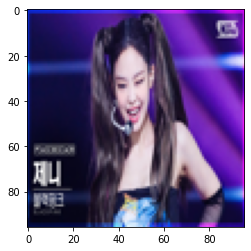

['Navy']


In [16]:
color_model('./sample.jpg')

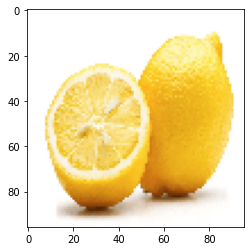

['Yellow']


In [17]:
color_model('./lemon.png')

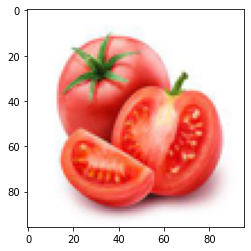

['Red']


In [18]:
color_model('./tomato.jfif')

## 2. 전체 코디 데이터로 모델 학습

In [19]:
target_list = ['Black', 'Navy', 'Pink', 'Green', 'Purple', 'Red', 'Skyblue', 'Yellow']
data = pd.DataFrame()

for color in target_list:
    photo_list = sorted(glob(f"./cody_image6/{color}/*.jpg"))
    
    for photo in photo_list:
        images = cv2.imread(photo)
        
        #RGB 평균 구하기
        arr1 = images[:,:,0].reshape(-1)
        r_mean = arr1[arr1 != 0].mean()
        
        arr1 = images[:,:,1].reshape(-1)
        g_mean = arr1[arr1 != 0].mean()
        
        arr1 = images[:,:,2].reshape(-1)
        b_mean = arr1[arr1 != 0].mean()
        
        #RGB 사이의 차이값 구하기
        rb_diff = abs(r_mean - b_mean)
        rg_diff = abs(r_mean - g_mean)
        gb_diff = abs(g_mean - b_mean)        
        
        pix = cv2.cvtColor(images, cv2.COLOR_BGR2HSV)
        pix_h_data = pix[:,:,0].reshape(-1)  #H부분만 추출
        #all_mean_v = pix[:,:,2].reshape(-1).mean()  #전체 평균 v
        
        unique, counts = np.unique(pix_h_data, return_counts=True)
        color_dict = dict(zip(unique, counts))
        sort_color = dict(sorted(color_dict.items(), key = lambda x: x[1], reverse = True)).keys()
        color_data = pd.DataFrame({'h_mean': [(np.array(list(sort_color))[0:6]).mean()]})  #대표색상 6개의 평균
        
        color_data['r_mean'] = r_mean
        color_data['g_mean'] = g_mean
        color_data['b_mean'] = b_mean
        
        color_data['rb_diff'] = rb_diff
        color_data['rg_diff'] = rg_diff
        color_data['gb_diff'] = gb_diff        
        
        color_data['target'] = color
        
        data = pd.concat([data, color_data], axis = 0)
        
#인덱스 번호 생성
data.reset_index(drop = True, inplace = True)
data

,h_mean,r_mean,g_mean,b_mean,rb_diff,rg_diff,gb_diff,target
0,110.000000,173.811083,163.222452,181.941606,8.130523,10.588632,18.719154,Black
1,90.000000,181.832328,173.950654,176.168512,5.663816,7.881674,2.217858,Black
2,100.000000,182.490479,176.456485,186.994426,4.503947,6.033994,10.537941,Black
3,91.666667,151.450456,114.542337,150.624113,0.826342,36.908119,36.081777,Black
4,87.500000,159.767308,154.407011,157.042933,2.724375,5.360297,2.635922,Black
...,...,...,...,...,...,...,...,...
3047,24.000000,172.638823,208.888197,215.429316,42.790493,36.249374,6.541119,Yellow
3048,36.166667,180.781970,210.327092,214.412662,33.630692,29.545122,4.085570,Yellow
3049,63.166667,193.538462,214.303634,236.659730,43.121269,20.765173,22.356096,Yellow
3050,16.666667,171.188208,211.240977,233.836998,62.648790,40.052770,22.596020,Yellow


In [20]:
#X, y 분리
X = data.drop('target', axis = 1)
y = data['target']

#랜덤 포레스트 모델 생성
rf = RandomForestClassifier(n_estimators = 300, min_samples_split = 6, min_samples_leaf = 1, n_jobs=-1)
rf.fit(X, y)

RandomForestClassifier(min_samples_split=6, n_estimators=300, n_jobs=-1)

## 3. 아이콘 데이터 색 예측

In [21]:
#아이콘 데이터 불러오기
icon_list = ['Cash', 'Hat', 'Overall']
icon_data = pd.DataFrame()

for icon in icon_list:
    photo_list = sorted(glob(f"./icon3/{icon}/*.png"))
    
    for photo in photo_list:
        img_array = np.fromfile(photo, np.uint8)
        images = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)
        #images = cv2.resize(images, (96, 96))
        
        #RGB 평균 구하기
        arr1 = images[:,:,0].reshape(-1)
        r_mean = arr1[arr1 != 0].mean()
        
        arr1 = images[:,:,1].reshape(-1)
        g_mean = arr1[arr1 != 0].mean()
        
        arr1 = images[:,:,2].reshape(-1)
        b_mean = arr1[arr1 != 0].mean()        
        
        #RGB 사이의 차이값 구하기
        rb_diff = abs(r_mean - b_mean)
        rg_diff = abs(r_mean - g_mean)
        gb_diff = abs(g_mean - b_mean)        
        
        pix = cv2.cvtColor(images, cv2.COLOR_BGR2HSV)
        pix_h_data = pix[:,:,0].reshape(-1)  #H부분만 추출
        #all_mean_v = pix[:,:,2].reshape(-1).mean()  #전체 평균 V
        
        try:
            unique, counts = np.unique(pix_h_data, return_counts=True)
            color_dict = dict(zip(unique, counts))
            sort_color = dict(sorted(color_dict.items(), key = lambda x: x[1], reverse = True)).keys()
            color_data = pd.DataFrame({'h_mean': [(np.array(list(sort_color))[0:6]).mean()]})  #대표색상 6개의 평균
        
            color_data['r_mean'] = r_mean
            color_data['g_mean'] = g_mean
            color_data['b_mean'] = b_mean
        
            color_data['rb_diff'] = rb_diff
            color_data['rg_diff'] = rg_diff
            color_data['gb_diff'] = gb_diff
        
            color_data['photo_address'] = photo
        
            icon_data = pd.concat([icon_data, color_data], axis = 0)
        
        except:
            continue
            
#인덱스 번호 생성
icon_data.reset_index(drop = True, inplace = True)
icon_data

C:\Users\playdata\AppData\Local\Temp\ipykernel_23296\3015511084.py:21: RuntimeWarning: Mean of empty slice.
  b_mean = arr1[arr1 != 0].mean()
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\playdata\AppData\Local\Temp\ipykernel_23296\3015511084.py:15: RuntimeWarning: Mean of empty slice.
  r_mean = arr1[arr1 != 0].mean()
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\playdata\AppData\Local\Temp\ipykernel_23296\3015511084.py:15: RuntimeWarning: Mean of empty slice.
  r_mean = arr1[arr1 != 0].mean()
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\playdata\AppData\Local\Temp\ipykernel_23296\3015511084.py:18:

,h_mean,r_mean,g_mean,b_mean,rb_diff,rg_diff,gb_diff,photo_address
0,95.166667,216.516484,183.926199,161.531365,54.985118,32.590284,22.394834,./icon3/Cash\GM노리의 주사기.png
1,90.166667,148.008310,139.084388,139.908844,8.099467,8.923922,0.824455,./icon3/Cash\New 모자 속 토끼.png
2,8.333333,101.415913,133.652098,222.355482,120.939569,32.236185,88.703384,./icon3/Cash\RED 페인트통.png
3,110.500000,153.329945,54.448399,76.658582,76.671362,98.881546,22.210184,./icon3/Cash\[BTS] 라스트 페더.png
4,115.333333,233.772890,134.950998,194.492819,39.280072,98.821892,59.541820,./icon3/Cash\[BTS] 아미밤.png
...,...,...,...,...,...,...,...,...
2069,78.750000,105.625259,93.060041,89.082816,16.542443,12.565217,3.977226,./icon3/Overall\흑백영화 주인공.png
2070,17.000000,116.323204,180.550136,218.834688,102.511484,64.226931,38.284553,./icon3/Overall\흑설탕 우유 멜빵.png
2071,64.166667,148.533163,194.415816,156.391076,7.857913,45.882653,38.024740,./icon3/Overall\희망 봄 나들이.png
2072,32.500000,167.174581,196.402235,221.664804,54.490223,29.227654,25.262570,./icon3/Overall\희망의 별.png


In [22]:
#결측치 삭제
icon_data.dropna(inplace = True)

#예측 및 결과 반환
X_test = icon_data.drop('photo_address', axis = 1)
icon_pred = []; icon_prob = []

for i in range(len(X_test)):
    X = pd.DataFrame(X_test.iloc[i, :]).T
    
    icon_pred.append(rf.predict(X))
    icon_prob.append(rf.predict_proba(X))
    
icon_data['color_pred'] = icon_pred
icon_data['color_prob'] = icon_prob

In [23]:
#아이템 이름만 가져오기
def get_name(x):
    return x['photo_address'].split('\\')[1][:-4]

icon_data['icon_name'] = icon_data.apply(get_name, axis = 1)

#아이템 이름을 기준으로 아이템 이미지 주소값 연결
item_data = pd.read_csv('item_data.csv', encoding = 'euc-kr', index_col = 0)

newdata = pd.merge(icon_data, item_data, left_on = 'icon_name', right_on = 'item_name', how = 'left')

#중복 데이터 삭제
newdata = newdata.drop_duplicates(['icon_name', 'item_name'], keep = 'first')
newdata.reset_index(drop = True, inplace = True)

#데이터프레임 수정
def color_str_change(x):
    return x['color_pred'][0]

newdata['color_pred'] = newdata.apply(color_str_change, axis = 1)

newdata.drop(['icon_name'], axis = 1, inplace = True)

In [24]:
final_data = newdata[['item_id', 'item_name', 'item_category', 'item_url', 'color_pred']]
#final_data.to_csv('final_data3.csv', encoding = 'euc-kr')

In [ ]:
#예측된 아이콘 데이터 분류하여 내부에 저장(분류가 잘 됐는지 눈으로 확인하기 위함)
for i in range(len(newdata)):
    try:
        item_url = newdata['item_url'][i]
        item_name = newdata['item_name'][i]
        item_color = newdata['color_pred'][i]
        item_category = newdata['item_category'][i]

        response = requests.get(item_url)

        with open(f'./ModelResult/Final/{item_color}/{item_category}/{item_name}.png', 'wb') as f:
            f.write(response.content)
    except:
        continue

## 4. 새로운 사진 input 및 색 탐지

In [25]:
#모델 먼저 불러오기
cody_data = pd.read_csv('./cody_data.csv', encoding = 'euc-kr', index_col = 0)

#X, y 분리
X = cody_data.drop('target', axis = 1)
y = cody_data['target']

#랜덤 포레스트 모델 생성 및 예측
rf = RandomForestClassifier(n_estimators = 300, min_samples_split = 6, min_samples_leaf = 1, n_jobs=-1)
rf.fit(X, y)

RandomForestClassifier(min_samples_split=6, n_estimators=300, n_jobs=-1)

In [26]:
#새로운 이미지의 색을 분류해주는 함수 코드
def color_model(photo):
    img_array = np.fromfile(photo, np.uint8)
    images = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)

    image_open = Image.open(photo).resize((96, 96))
    plt.imshow(image_open)
    plt.show()

    #RGB 평균 구하기
    arr1 = images[:,:,0].reshape(-1)
    r_mean = arr1[arr1 != 0].mean()

    arr1 = images[:,:,1].reshape(-1)
    g_mean = arr1[arr1 != 0].mean()

    arr1 = images[:,:,2].reshape(-1)
    b_mean = arr1[arr1 != 0].mean()

    #RGB 사이의 차이값 구하기
    rb_diff = abs(r_mean - b_mean)
    rg_diff = abs(r_mean - g_mean)
    gb_diff = abs(g_mean - b_mean)        

    pix = cv2.cvtColor(images, cv2.COLOR_BGR2HSV)
    pix_h_data = pix[:,:,0].reshape(-1)  #H부분만 추출
    #all_mean_v = pix[:,:,2].reshape(-1).mean()  #전체 평균 v

    unique, counts = np.unique(pix_h_data, return_counts=True)
    color_dict = dict(zip(unique, counts))
    sort_color = dict(sorted(color_dict.items(), key = lambda x: x[1], reverse = True)).keys()
    color_data = pd.DataFrame({'h_mean': [(np.array(list(sort_color))[0:6]).mean()]})  #대표색상 6개의 평균

    color_data['r_mean'] = r_mean
    color_data['g_mean'] = g_mean
    color_data['b_mean'] = b_mean

    color_data['rb_diff'] = rb_diff
    color_data['rg_diff'] = rg_diff
    color_data['gb_diff'] = gb_diff

    #모델을 통한 색상 예측
    print(rf.predict(color_data))
    
    return rf.predict(color_data)[0]

이미지를 넣어주세요.: maple1.jpg


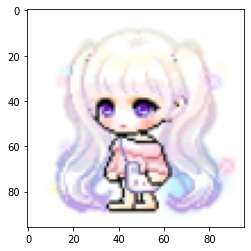

['Purple']


In [27]:
#test_image = ./노란색.png
photo = input('이미지를 넣어주세요.: ')
color_pred = color_model(photo)

## 5. 만족도 데이터를 활용하여 코디 추출

In [28]:
#서버에 접속해서 누적 데이터 불러오기
# STEP 1: MySQL Connection 연결
con = pymysql.connect(host='maple.mysql.database.azure.com', user='maple', password='giveup0930@',
                      db='project', charset='utf8', port= 3306,
                      autocommit=True, cursorclass=pymysql.cursors.DictCursor)

# STEP 2: Connection 으로부터 Cursor 생성
cur = con.cursor()

# STEP 3: item_id, score 만 검색
query = "select item_id,score from maple"

# STEP 4: query 실행
cur.execute(query)

# STEP 5: 딕션너리로 불러오기
result = cur.fetchall()

# STEP 3: 판다스 변환
df = pd.DataFrame(result)

In [29]:
df_score = df.groupby(['item_id'])['score'].mean()

final_data = pd.read_csv('final_data3.csv', encoding = 'euc-kr', index_col = 0)
final_data = pd.merge(final_data, df_score, on = 'item_id', how = 'left')

#만족도 데이터가 없는 아이템은 3으로 지정(기본값)
final_data['score'].fillna(3, inplace = True)

In [30]:
item_list = ['Cash', 'Hat', 'Overall']
choice = []

#랜덤으로 3개를 추출하여 id를 리스트에 저장
for item_category in item_list:
    choice_data = final_data[(final_data['color_pred'] == color_pred) & (final_data['item_category'] == item_category)]
    random_num = random.choices(choice_data['item_id'].tolist(), weights = choice_data['score'].tolist(), k = 3)
    choice.append(random_num)

In [31]:
#API 호출 및 코디 이미지 불러오기
for i in range(3):
    hair_code = {"itemId": 61190, "version": "367", "region": "KMS"}
    cash_code = {"itemId": choice[0][i], "version": "367", "region": "KMS"}
    hat_code = {"itemId": choice[1][i], "version": "367", "region": "KMS"}
    overall_code = {"itemId": choice[2][i], "version": "367", "region": "KMS"}
    face_code = {"itemId": 21078, "version": "367", "region": "KMS"}
    skin_code1 = {"itemId": 2016, "version": "367", "region": "KMS"}
    skin_code2 = {"itemId": 12016, "version": "367", "region": "KMS"}

    url = f'https://maplestory.io/api/character/{skin_code1},{skin_code2},{hair_code},{cash_code},{hat_code},{overall_code},{face_code}/stand1/0?showears=false&showLefEars=false&showHighLefEars=undefined&resize=1&name=&flipX=false&bgColor=0,0,0,0'
    response = requests.get(url)
    image_url = response.url
    
    print(f'-------{i}번째 코디------')
    print(image_url, '\n')

-------0번째 코디------
https://maplestory.io/api/character/%7B'itemId':%202016,%20'version':%20'367',%20'region':%20'KMS'%7D,%7B'itemId':%2012016,%20'version':%20'367',%20'region':%20'KMS'%7D,%7B'itemId':%2061190,%20'version':%20'367',%20'region':%20'KMS'%7D,%7B'itemId':%201703022,%20'version':%20'367',%20'region':%20'KMS'%7D,%7B'itemId':%201005651,%20'version':%20'367',%20'region':%20'KMS'%7D,%7B'itemId':%201051653,%20'version':%20'367',%20'region':%20'KMS'%7D,%7B'itemId':%2021078,%20'version':%20'367',%20'region':%20'KMS'%7D/stand1/0?showears=false&showLefEars=false&showHighLefEars=undefined&resize=1&name=&flipX=false&bgColor=0,0,0,0 

-------1번째 코디------
https://maplestory.io/api/character/%7B'itemId':%202016,%20'version':%20'367',%20'region':%20'KMS'%7D,%7B'itemId':%2012016,%20'version':%20'367',%20'region':%20'KMS'%7D,%7B'itemId':%2061190,%20'version':%20'367',%20'region':%20'KMS'%7D,%7B'itemId':%201703004,%20'version':%20'367',%20'region':%20'KMS'%7D,%7B'itemId':%201005876,%20'versi